In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("d:\\Downloads\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
print(CountOfClasses)
logos_list

8


['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cpu


In [4]:
path = 'd:\\Downloads\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\Train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((60,60)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True,num_workers=4)

(tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.7765, 0.7725, 0.7725],
         [0.7961, 0.7961, 0.7961,  ..., 0.7843, 0.7765, 0.7686],
         [0.7961, 0.7961, 0.7961,  ..., 0.7804, 0.7686, 0.7647],
         ...,
         [0.9255, 0.7216, 0.7451,  ..., 0.9725, 0.9725, 0.9882],
         [0.9647, 0.7647, 0.6745,  ..., 0.9137, 0.9137, 0.9804],
         [0.9922, 0.9569, 0.9176,  ..., 0.9882, 0.9922, 0.9961]],

        [[0.8549, 0.8549, 0.8549,  ..., 0.8353, 0.8353, 0.8314],
         [0.8549, 0.8549, 0.8549,  ..., 0.8431, 0.8353, 0.8275],
         [0.8549, 0.8549, 0.8549,  ..., 0.8392, 0.8275, 0.8235],
         ...,
         [0.9451, 0.8235, 0.8431,  ..., 0.9725, 0.9725, 0.9882],
         [0.9765, 0.8431, 0.7843,  ..., 0.9137, 0.9137, 0.9804],
         [0.9882, 0.9765, 0.9529,  ..., 0.9882, 0.9922, 0.9961]],

        [[0.9451, 0.9451, 0.9451,  ..., 0.8980, 0.9098, 0.9216],
         [0.9451, 0.9451, 0.9451,  ..., 0.9059, 0.9098, 0.9176],
         [0.9451, 0.9451, 0.9451,  ..., 0.9020, 0.9020, 0

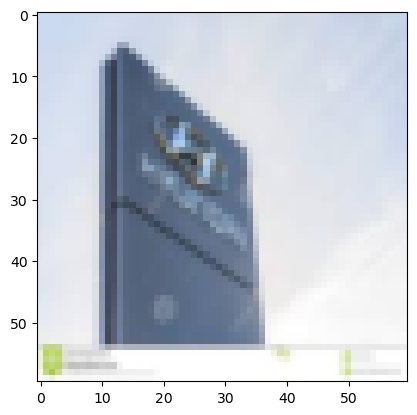

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,4*base_ch)

    cna3_1=CNA(4*base_ch,8*base_ch)
    cna3_2=CNA(8*base_ch,8*base_ch)
    
    cna4_1=CNA(8*base_ch,16*base_ch)
    # cna4_2=CNA(8*base_ch,8*base_ch)

    # cna5_1=CNA(8*base_ch,8*base_ch)
    # cna5_2=CNA(8*base_ch,8*base_ch)
    
    act=nn.ReLU()

    Linear_1=nn.Linear(16*base_ch,8*base_ch)
    Linear_2=nn.Linear(8*base_ch,2*base_ch)
    #Linear_3=nn.Linear(16*base_ch,8*base_ch)
    Linear_4=nn.Linear(2*base_ch,CountOfClasses)

    maxpool=nn.MaxPool2d((2,2),stride=2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,avgpool,
          #cna5_1,cna5_2,avgpool,
          flatten,
          Linear_1,act,
          Linear_2,act,
          #Linear_3,act,
          Linear_4
          
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
# vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)
# classifier=nn.Sequential(
#     nn.Linear(25088,600),
#     nn.ReLU(),
#     nn.Linear(600,600),
#     nn.ReLU(),
#     nn.Linear(600,CountOfClasses)
# )
# vggNet.classifier=classifier
# for param in vggNet.features.parameters():
#     param.requires_grad=False
# #net = SimpleConvNet()
# net=vggNet
# net = net.to(device)

In [12]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
#optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

9263944


In [13]:
def get_accuracy(pred, label):
    answer =(pred.argmax(1)==label.argmax(1)).type(torch.float).sum().item()

    #answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer

In [14]:
#net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [15]:
epochs=20
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)
        
        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)*16
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

epoch= 0 loss= 0.10314130297378649 accruracy= 0.28283227848101267
epoch= 1 loss= 0.09166534858036644 accruracy= 0.4149525316455696
epoch= 2 loss= 0.08016949597321733 accruracy= 0.5019778481012658
epoch= 3 loss= 0.06666060074975219 accruracy= 0.6301424050632911
epoch= 4 loss= 0.05423377692416499 accruracy= 0.7068829113924051
epoch= 5 loss= 0.04382015036749123 accruracy= 0.7681962025316456
epoch= 6 loss= 0.03684337779620214 accruracy= 0.8085443037974683


In [ ]:
torch.save(net, 'D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [ ]:
#net = MyConvModel()
#net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')
#net.eval()

Test for one image

tensor([[0.2500, 0.1875, 0.1651, 0.1003, 0.0610, 0.1155, 0.0769, 0.1678]],
       grad_fn=<AddmmBackward0>)
[0.2500239908695221, 0.18746216595172882, 0.1650862991809845, 0.10026644915342331, 0.0610046461224556, 0.11551427841186523, 0.07686367630958557, 0.1678069829940796]
0.2500239908695221
0
hyundai
1.1240284889936447


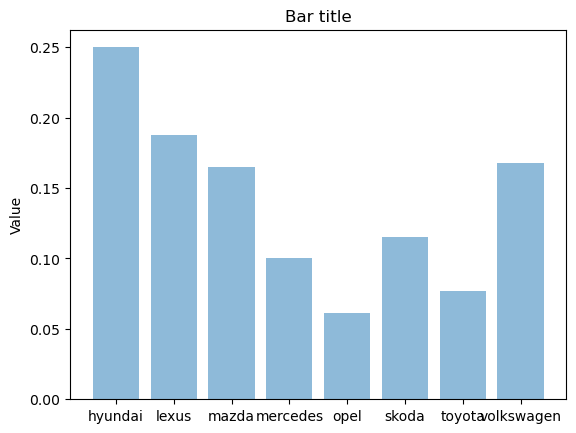

In [ ]:
path="d:\\Downloads\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\mytest\\2.jpg"
img=Image.open(path)
tensorImg=transforms(img)
batchImg=torch.unsqueeze(tensorImg,0)
out=net(batchImg)
print(out)
test=out
out=out.squeeze()
out=out.tolist()
print(out)
print(max(out))
print(out.index(max(out)))
print(logos_list[out.index(max(out))])
print(sum(out))
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, out, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()
# dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
# #print(dataset[0])
# testloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
# for sample in testloader:
#   img,label = sample
#   img=img.to(device)
#   pred=net(img)
  
#   pred=max(pred).tolist()
#   print(pred)
#   print(pred.index(max(pred)))
#   print(max(pred))
#   print(logos_list[ pred.index(max(pred))])

test for test dataset dataset img =1460

In [ ]:
a=np.zeros(CountOfClasses)
path = 'd:\\Downloads\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\Train'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)
print(sum(a))

loss= 0.11178616645727033 accruracy= 0.120175089534421
[2513.    0.    0.    0.    0.    0.    0.    0.]
2513.0


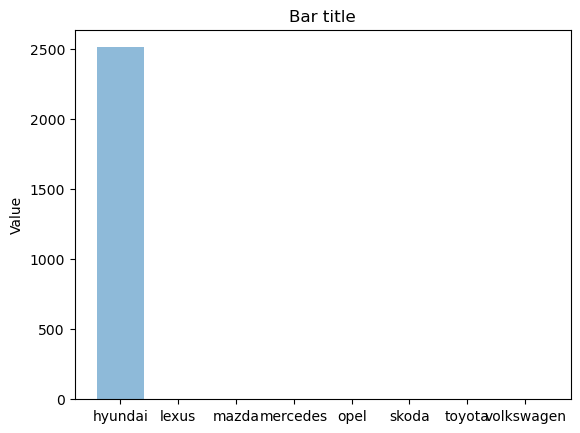

In [ ]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()

эта хуйня не работает